In [102]:
import pandas as pd
import numpy as np
from ete3 import Tree

PATH = "/Users/aleksandradenisova/Laboratory/innovation/Inno_2025/initial_data/"
tree = Tree(f"{PATH}/tree_clootl.newick", format=1)

toga_table = pd.read_csv(
    "/Users/aleksandradenisova/Laboratory/innovation/Inno_2025/initial_data/overview.table.corrected.tsv",
    sep = "\t"
)
toga_sp = set(toga_table["Species"])

print(f"toga contains {len(toga_sp)} species")

tax_df = pd.read_csv(f"{PATH}/taxonomy_table.csv")
tax_df["Birdlife_name"] = tax_df["Birdlife_name"].str.split(";")
tax_df = tax_df.explode("Birdlife_name")

overlap_sp = tax_df.apply(
    lambda x: [i for i in {x.ott_name, x.H_M_name, x.Birdlife_name, x.IOC_name} if i in toga_sp],
    axis = 1
)
overlaping_sp_tax_df= overlap_sp.apply(lambda x: x[0] if x else np.nan)
tax_overlap = tax_df[~overlaping_sp_tax_df.isna()]

print(f"We were able to identify {len(tax_overlap['sci_name_2025'].unique())} species in tax_table")

toga contains 482 species
We were able to identify 483 species in tax_table


In [134]:
df = pd.read_csv(
    f"{PATH}/ALLBIRDTRAITS_Database_March_2026.csv"
)
print(f"Initial number of species: {len(df['Species'].unique())}")


inno_sp = {i.replace("_", " ") for i in set(df["Species"].unique())}
overlap_sp = tax_df.apply(
    lambda x: [i for i in {x.ott_name, x.H_M_name, x.Birdlife_name, x.IOC_name, x.sci_name_2025} if i in inno_sp],
    axis = 1
)
overlaping_sp_inno_df = overlap_sp.apply(lambda x: x[0] if x else np.nan)
tax_df["Species"] = overlaping_sp_inno_df.apply(lambda x: str(x).replace(" ", "_"))
inno_overlap = tax_df[~overlaping_sp_inno_df.isna()]

print(f"We were able to identify {len(inno_overlap['sci_name_2025'].unique())} species in tax_table")

[i.replace(" ", "_") for i in inno_overlap["sci_name_2025"].unique().tolist()]

overlap = (
    set([i.replace(" ", "_") for i in tax_overlap["sci_name_2025"].unique().tolist()]) &
    set([i.replace(" ", "_") for i in inno_overlap["sci_name_2025"].unique().tolist()])
)
tree.prune(
    overlap
)

print(f"finally we have tree with {len(tree.get_leaf_names())} species")

Initial number of species: 8887
We were able to identify 8885 species in tax_table
finally we have tree with 438 species


In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ete3 import Tree
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import get_cmap

sp_column_name = "sci_name_2025"
species_order = tree.get_leaf_names()

df = inno_overlap.merge(df)
df[sp_column_name] = df[sp_column_name].apply(lambda x: x.replace(" ", "_"))
df.drop_duplicates(subset = sp_column_name, inplace = True)

df = df.set_index(sp_column_name).loc[species_order].reset_index()

y = np.arange(len(species_order))
print(len(y))

438


/var/folders/fc/n8rj9g1j6_x12_dl3p0fqv7c0000gn/T/ipykernel_48911/375324346.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("RdYlGn")


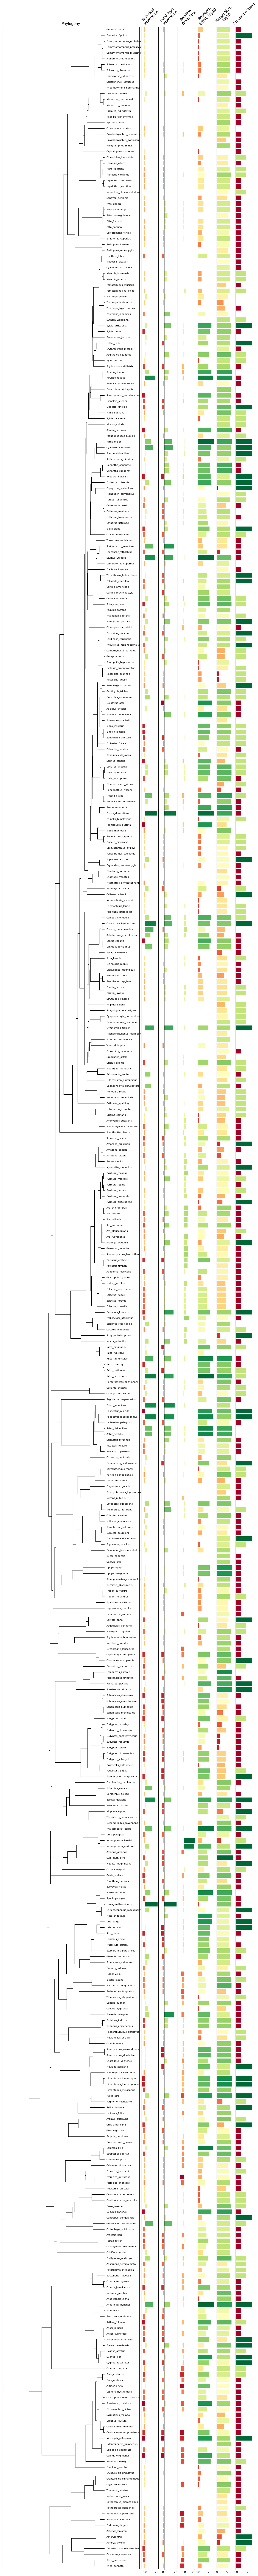

In [ ]:
df["Range_size_log"] = np.log10(df["Range_size"])
df["ResearchEffort_log"] = df["ResearchEffort"].apply(lambda x: np.log10(x) if x > 0 else 0)

population_trend_decoding = {
    'decreasing': 1, 
    'stable': 2, 
    'increasing': 3,
    'unknown': np.nan, 
    np.nan: np.nan
}
df["PopulationTrend2019_encoded"] = df["PopulationTrend2019"].apply(
    lambda x: population_trend_decoding[x]
)


values_of_interest = {
    "TECHINNO2025_ResEff": "Technical\nInnovation", 
    "FOODINNO2025_ResEff": "Food Type\nInnovation", 
    'Relative_brain_size': "Relative\nBrain Size", 
    'ResearchEffort_log': "Research\nEffort, log10", 
    "Range_size_log": "Range Size,\nlog10",
    'PopulationTrend2019_encoded': "Population Trend",
}


fig = plt.figure(figsize=(15, 0.35 * len(species_order)))
gs = fig.add_gridspec(1, len(values_of_interest)+1, width_ratios=[12] + [1.5]* len(values_of_interest), wspace=0.05)

ax_tree = fig.add_subplot(gs[0, 0])

for node in tree.traverse("postorder"):
    if node.is_leaf():
        node.y = species_order.index(node.name)
        node.x = 0
    else:
        node.y = np.mean([c.y for c in node.children])
        node.x = max(c.x + c.dist for c in node.children)


max_x = max(n.x for n in tree.traverse())
label_space = 0.35 * max_x
ax_tree.set_xlim(-0.02 * max_x, max_x + label_space)

for node in tree.traverse():
    node.x = max_x - node.x

for node in tree.traverse():
    if not node.is_root():
        ax_tree.plot([node.x, node.up.x], [node.y, node.y],
                     color="black", lw=0.8)
        ax_tree.plot([node.up.x, node.up.x], [node.y, node.up.y],
                     color="black", lw=0.8)

for sp, yy in zip(species_order, y):
    color = "black"   
    
    ax_tree.text(max_x + 0.02 * max_x, yy, sp,
                 va="center", fontsize=8, color=color)

ax_tree.set_ylim(-0.5, len(species_order) - 0.5)
ax_tree.invert_yaxis()
ax_tree.set_xticks([])
ax_tree.set_yticks([])
ax_tree.set_title("Phylogeny")

cmap = get_cmap("RdYlGn")

for i, val in enumerate(values_of_interest.keys()):
    ax_res  = fig.add_subplot(gs[0, i+1], sharey=ax_tree)

    norm_res = TwoSlopeNorm(
        vmin=df[val].min(),
        vcenter = df[val].mean(), 
        vmax=df[val].max()
    )


    ax_res.barh(
        y,
        df[val],
        color=cmap(norm_res(df[val]))
    )
    ax_res.axvline(0, color="black", lw=0.8)
    ax_res.set_title(values_of_interest[val], rotation=45)
    ax_res.set_yticks([])


plt.subplots_adjust(wspace=0.05)
plt.show()

fig.savefig(
    f"tree_toga_tech_inno_selection.pdf", 
    format='pdf', 
    dpi=600,
    bbox_inches="tight"
)

